# Colour catchment areas by transfer unit

This notebook shows how to assign colours to all stroke unit catchment areas so all units sharing a transfer unit are drawn in different shades of the same colour and no two adjacent regions are drawn in the same shade.

# Notebook setup

In [1]:
import stroke_maps.load_data
import stroke_maps.catchment
import stroke_maps.geo

import pandas as pd
import matplotlib.pyplot as plt
from mapclassify import greedy  # to assign colours to regions on map.
                                # ^ also requires libpysal.

## Load data

__Stroke unit services__ for the calculations and __coordinates__ for the maps

In [2]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

gdf_units = stroke_maps.load_data.stroke_unit_coordinates()
# Merge the services information into the coordinates:
gdf_units = pd.merge(
    gdf_units, df_units[['use_ivt', 'use_mt']],
    left_index=True, right_index=True, how='right'
)

__LSOA travel time__ for the calculations

In [3]:
df_travel_lsoa = stroke_maps.load_data.travel_time_matrix_lsoa()

__LSOA boundaries__ for the maps

In [4]:
gdf_lsoa = stroke_maps.load_data.lsoa_geography()

## Calculate LSOA catchment areas

First we'll create catchment areas of all acute stroke units.

Limit the travel time matrix to only stroke units that offer acute care. These are units where `use_ivt` and/or `use_mt` are equal to 1 (one).

In [5]:
mask = ((df_units['use_ivt'] == 1) | (df_units['use_mt'] == 1))
postcodes_units = df_units[mask].index.values

# Load the travel time matrix:
df_travel_lsoa = stroke_maps.load_data.travel_time_matrix_lsoa()
# Limit it to these units:
df_travel_lsoa = df_travel_lsoa[postcodes_units].copy()

# Run the function to find which of the units in the reduced dataframe
# is closest to each LSOA:
df_catchment = stroke_maps.catchment.find_nearest_unit(df_travel_lsoa)

Combine this data with geometry:

In [6]:
# Merge in the information on nearest acute stroke unit:
gdf_lsoa = pd.merge(
    gdf_lsoa, df_catchment['unit_postcode'],
    left_on='LSOA11NM', right_index=True, how='right'
)
# Combine LSOA with the same acute stroke unit into a single region:
gdf_catchment = stroke_maps.geo.combine_regions(gdf_lsoa, 'unit_postcode')
# Convert the coordinates to British National Grid so that they match other geometry:
gdf_catchment = gdf_catchment.to_crs('EPSG:27700')
# Assign colour numbers.
# Use 'distance' balance to use as few colours as possible.
gdf_catchment['adjacent_colours'] = greedy(
    gdf_catchment, min_distance=1, balance='distance').astype(str)

## Calculate transfer units

Now find which stroke units have which transfer units.

In [7]:
df_transfer = stroke_maps.catchment.calculate_transfer_units(df_units)

Create a GeoDataFrame of Line objects connecting each start unit to its transfer unit:

In [8]:
gdf_transfer = stroke_maps.geo.make_geometry_transfer_units(df_transfer)

## Assign colours by transfer unit

First merge the transfer unit data into the catchment regions:

In [9]:
# Change the index name to match gdf_catchment index name:
df_transfer.index.name = 'unit_postcode'

In [10]:
gdf_catchment = pd.merge(
    gdf_catchment, df_transfer,
    left_index=True, right_index=True, how='left'
)

Then combine the regions to get one bigger region per transfer unit:

In [11]:
gdf_catchment_transfer = gdf_catchment.copy()
gdf_catchment_transfer = gdf_catchment_transfer.reset_index()
gdf_catchment_transfer = stroke_maps.geo.combine_regions(
    gdf_catchment_transfer, 'transfer_unit_postcode')

And assign colours so no adjacent transfer units have the same colour:

In [12]:
# Assign colour numbers.
# Use 'distance' balance to use as few colours as possible.
gdf_catchment_transfer['adjacent_colours'] = greedy(
    gdf_catchment_transfer, min_distance=1, balance='distance').astype(str)

Merge the transfer colour numbers back into the general catchment data:

In [13]:
gdf_catchment = pd.merge(
    gdf_catchment, gdf_catchment_transfer['adjacent_colours'],
    left_on='transfer_unit_postcode', right_index=True,
    how='left', suffixes=[None, '_transfer']
)

In [14]:
gdf_catchment.head(5)

,geometry,adjacent_colours,transfer_unit_travel_time,transfer_unit_postcode,adjacent_colours_transfer
unit_postcode,,,,,
B152TH,"MULTIPOLYGON (((416305.700 265602.906, 417069....",3,0.0,B152TH,0
B714HJ,"MULTIPOLYGON (((399681.915 286423.006, 399888....",2,18.7,B152TH,0
BA13NG,"MULTIPOLYGON (((390560.691 145587.417, 389463....",4,33.7,BS105NB,1
BA214AT,"MULTIPOLYGON (((332368.011 102237.393, 333313....",5,74.5,BS105NB,1
BB23HH,"POLYGON ((370868.322 414133.507, 370698.959 41...",4,26.2,PR29HT,2


## Assign colours

Use the following colour maps:

In [15]:
# Pick sequential colourmaps that go from light (0.0) to dark (1.0).
cmaps_list = [
    'Blues', 'Greens', 'Oranges', 'Purples', 'Reds',
    'YlOrBr', 'RdPu', 'BuGn', 'YlOrRd', 'BuPu',
]
# Pick colours out of the colour maps in this order:
cmaps_inds = [0.5, 0.375, 0.625, 0.25, 0.75, 0.125, 0.875, 0.0, 1.0]

In [16]:
# Make a dictionary of a list of colours for each colour map.
colour_dict = {}

for cmap_name in cmaps_list:
    cmap = plt.get_cmap(cmap_name)
    colours = cmap(cmaps_inds)

    colour_dict[cmap_name] = colours

Sample each colour map to get a list of colours:

In [18]:
assigned_colours = []
for postcode in gdf_catchment.index:
    cmap_name = cmaps_list[int(gdf_catchment.loc[postcode, 'adjacent_colours_transfer'])]
    cmap_ind = int(gdf_catchment.loc[postcode, 'adjacent_colours'])

    # Pick the colour out of the colour dictionary:
    colour = colour_dict[cmap_name][cmap_ind]
    assigned_colours.append(colour)

gdf_catchment['colour'] = assigned_colours

In [19]:
gdf_catchment.head(5)

,geometry,adjacent_colours,transfer_unit_travel_time,transfer_unit_postcode,adjacent_colours_transfer,colour
unit_postcode,,,,,,
B152TH,"MULTIPOLYGON (((416305.700 265602.906, 417069....",3,0.0,B152TH,0,"[0.7752402921953095, 0.8583006535947711, 0.936..."
B714HJ,"MULTIPOLYGON (((399681.915 286423.006, 399888....",2,18.7,B152TH,0,"[0.25628604382929643, 0.5700115340253749, 0.77..."
BA13NG,"MULTIPOLYGON (((390560.691 145587.417, 389463....",4,33.7,BS105NB,1,"[0.1340253748558247, 0.5423298731257208, 0.268..."
BA214AT,"MULTIPOLYGON (((332368.011 102237.393, 333313....",5,74.5,BS105NB,1,"[0.8975778546712803, 0.9605997693194925, 0.877..."
BB23HH,"POLYGON ((370868.322 414133.507, 370698.959 41...",4,26.2,PR29HT,2,"[0.8462745098039215, 0.28069204152249133, 0.00..."


## Plot the map

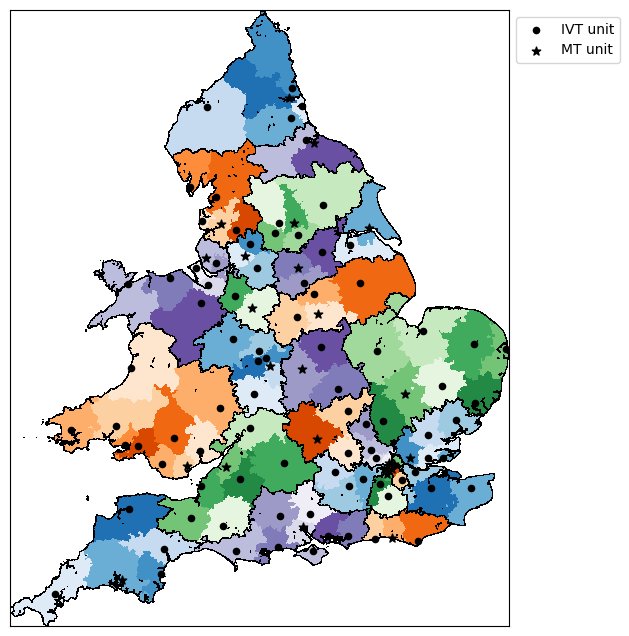

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))

# Catchment areas:
gdf_catchment.plot(
    ax=ax,              # Set which axes to use for plot
    antialiased=False,  # Avoids artefact boundary lines
    color=gdf_catchment['colour'],  # set colours using this column
    linewidth=0.2,
    )

# Transfer unit catchment boundaries:
gdf_catchment_transfer.plot(
    ax=ax,              # Set which axes to use for plot
    antialiased=False,  # Avoids artefact boundary lines
    facecolor='none',  # set colours using this column
    edgecolor='k',
    linewidth=0.2,
    )

# Pick out which stroke units to plot:
mask_ivt = ((gdf_units['use_ivt'] == 1) & (gdf_units['use_mt'] == 0))
mask_mt = (gdf_units['use_mt'] == 1)

# IVT units:
ax.scatter(
    gdf_units.loc[mask_ivt, 'geometry'].x,
    gdf_units.loc[mask_ivt, 'geometry'].y,
    marker='o',
    facecolor='k',
    label='IVT unit',
    s=20,  # size
    )

# MT units:
ax.scatter(
    gdf_units.loc[mask_mt, 'geometry'].x,
    gdf_units.loc[mask_mt, 'geometry'].y,
    marker='*',
    facecolor='k',
    label='MT unit',
    s=40,  # size
    )

# Axis limits:
bounds = gdf_catchment.geometry.total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Remove the axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add legend:
ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

plt.show()